In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import copy

In [5]:
path = '../DATA'
trainFile = 'train.csv'
testFile = 'test.csv'

In [6]:
train_df = pd.read_csv(os.path.join(path, trainFile),
                       header = 0,
                       index_col=False)
test_df = pd.read_csv(os.path.join(path, testFile),
                      header = 0,
                      index_col=False)


In [202]:
train_df.head()

,id,wi,year,month,age,education,familysize,urban,race,region,state,marital,occupation,income,expense
0,1,2831.0,2002,1,50,12,3,2,2,3.0,NaN,3,2.0,13141,2398
1,2,1941.0,2002,1,23,13,1,1,4,4.0,16.0,5,11.0,0,575
2,3,1369.0,2002,1,56,15,4,1,1,3.0,12.0,3,4.0,459,1592
3,4,816.0,2002,1,59,17,2,1,1,3.0,24.0,1,7.0,17474,3443
4,5,3064.0,2002,1,51,15,2,1,1,3.0,NaN,1,1.0,39395,1484


In [203]:
test_df.head()

,id,year,month,age,education,familysize,urban,race,region,state,marital,occupation,income
0,741875,2002,1,49,13,1,1,2,1.0,36.0,5,4.0,0
1,741876,2002,1,29,12,4,1,1,4.0,49.0,1,1.0,11628
2,741877,2002,1,22,13,1,1,1,4.0,41.0,5,NaN,0
3,741878,2002,1,78,12,2,1,1,4.0,4.0,2,NaN,13413
4,741879,2002,1,25,15,2,1,1,4.0,6.0,5,2.0,0


# Feature augmentation

In [206]:
BLSDatasets = {'CPIUrban':['monthly', 'one-to-one'],
              'LaborForceParticip':['monthly', 'one-to-one'],
              'UnemploymentRateByAge':['monthly', 'range', 'age'],
              'AnnualExpenditureByAge':['annual', 'range', 'age'],
              'AnnualExpenditureByIncome':['annual', 'range', 'income'],
              'AnnualExpenditureByFamilySize':['annual', 'range', 'familysize']}

refLookup = {'AnnualExpenditureByAge': {0: 'CXUTOTALEXPLB0402M', 25: 'CXUTOTALEXPLB0403M', 35: 'CXUTOTALEXPLB0404M', 45: 'CXUTOTALEXPLB0405M', 55: 'CXUTOTALEXPLB0406M', 65: 'CXUTOTALEXPLB0408M',  75: 'CXUTOTALEXPLB0409M'},
             'AnnualExpenditureByIncome': {0: 'CXUTOTALEXPLB0202M', 5000: 'CXUTOTALEXPLB0203M', 10000: 'CXUTOTALEXPLB0204M', 15000: 'CXUTOTALEXPLB0205M', 20000: 'CXUTOTALEXPLB0206M', 30000: 'CXUTOTALEXPLB0207M', 40000: 'CXUTOTALEXPLB0208M', 50000: 'CXUTOTALEXPLB0209M', 70000: 'CXUTOTALEXPLB0210M'},            
             'AnnualExpenditureByFamilySize': {1: 'CXUTOTALEXPLB0502M', 2: 'CXUTOTALEXPLB0504M', 3: 'CXUTOTALEXPLB0505M', 4: 'CXUTOTALEXPLB0506M', 5: 'CXUTOTALEXPLB0507M'},
             'UnemploymentRateByAge': {15: 'LNU04000086', 18: 'LNU04000088', 20: 'LNU04000036', 25: 'LNU04024932', 30: 'LNU04024933',  35: 'LNU04024934', 40: 'LNU04024935', 45: 'LNU04024936',  50: 'LNU04024937', 55:  'LNU04000094', 60: 'LNU04000096', 65: 'LNU04024938', 70: 'LNU04024941'}}


for dfType in range(2):
    if dfType == 0:
        df = train_df
    else:
        df = test_df
    
    # Add days in month and days in previous month as numeric values
    # assuming months are represented by when they occur in the year
    # assuming 28 days in feb for leap year
    df['daysInMonth'] = df.apply(lambda row: 28 if row.month==2 else (30 if row.month in [4, 6, 9, 11] else 31), axis=1)    
    df['daysInPrevMonth'] = df.apply(lambda row: 28 if row.month==3 else (30 if row.month in [5, 7, 10, 12] else 31), axis=1)
    df.loc[df['month'] == 2, 'daysInMonth'] = 28.0
    df.loc[df['month'].isin([4, 6, 9, 11]), 'daysInMonth'] = 30.0
    df['daysInMonth'].fillna(31.0, inplace=True)
    df.loc[df['month'] == 3, 'daysInPrevMonth'] = 28.0
    df.loc[df['month'].isin([5, 7, 10, 12]), 'daysInPrevMonth'] = 30.0
    df['daysInPrevMonth'].fillna(31.0, inplace=True)
    
    # Add features from BLS
    for blsDS in BLSDatasets:
        bls_df = pd.read_csv(os.path.join(path, blsDS+'.csv'),
                           header = 0,
                           index_col=False)
        
        # Process monthly column
        if BLSDatasets[blsDS][0] == 'monthly':
            bls_df['Period']= bls_df['Period'].str.replace('M', '')
            bls_df['Period'] = pd.to_numeric(bls_df['Period'])
            bls_df.rename(columns={'Period': 'month'}, inplace=True)

            mergeOn = ['month', 'year']
        else:
            # These are all annual, for which we are using
            # the previous year's data, otherwise we are corruping data
            # with future values
            # Particularly for this case study where we want to predict expenses, 
            # current year expenditures would "dirty" the expense predictions
            bls_df['Year'] = bls_df['Year'] + 1
            
            mergeOn = ['year']

        # Rename other columns in prep for join
        bls_df.rename(columns={'Year': 'year'}, inplace=True)
        bls_df.rename(columns={'Value': blsDS}, inplace=True)
        
        print(f'{blsDS} columns: {list(bls_df.columns)}')

        keep = copy.copy(mergeOn)
        keep.append(blsDS)
        if BLSDatasets[blsDS][1] == 'range':
            refs = refLookup[blsDS]
            bls_df.rename(columns={'Series ID': 'low'}, inplace=True)
            bls_df['high'] = bls_df['low']
            k = list(refs.keys())
            v = list(refs.values())
            bls_df['low'].replace(v, k, inplace=True)
            k = k[1:]
            k.append(np.inf)
            bls_df['high'].replace(v, k, inplace=True)
            keep.extend(['low','high'])
            
            # filter cols
            print(f'{blsDS} keeping: {keep}')
            bls_df = bls_df[keep]
            
            # join
            merged = pd.merge(df, bls_df, on=mergeOn, how='outer')
            merged = merged.query(f'{BLSDatasets[blsDS][2]} >= low &  {BLSDatasets[blsDS][2]} < high')
            merged.drop(columns=['low','high'], inplace=True)
        
        else:
            # filter cols
            print(f'{blsDS} keeping: {keep}')
            bls_df = bls_df[keep]
            
            # join
            merged = pd.merge(df, bls_df, on=mergeOn)
            check_nan = merged[blsDS].isnull().values.any() 
            if check_nan:
                print(f'problem with {blsDS}')
            
        print(merged[blsDS].isnull().sum())        

        df = merged
    
    if dfType == 0:
        train_df = df 
        print(f'Done with training set')
    else:
        test_df = df 
        print(f'Done with test set')


CPIUrban columns: ['Series ID', 'year', 'month', 'Label', 'CPIUrban']
CPIUrban keeping: ['month', 'year', 'CPIUrban']
0
LaborForceParticip columns: ['Series ID', 'year', 'month', 'Label', 'LaborForceParticip']
LaborForceParticip keeping: ['month', 'year', 'LaborForceParticip']
0
UnemploymentRateByAge columns: ['Series ID', 'year', 'month', 'Label', 'UnemploymentRateByAge']
UnemploymentRateByAge keeping: ['month', 'year', 'UnemploymentRateByAge', 'low', 'high']
0
AnnualExpenditureByAge columns: ['Series ID', 'year', 'Period', 'Label', 'AnnualExpenditureByAge']
AnnualExpenditureByAge keeping: ['year', 'AnnualExpenditureByAge', 'low', 'high']
0
AnnualExpenditureByIncome columns: ['Series ID', 'year', 'Period', 'Label', 'AnnualExpenditureByIncome']
AnnualExpenditureByIncome keeping: ['year', 'AnnualExpenditureByIncome', 'low', 'high']
0
AnnualExpenditureByFamilySize columns: ['Series ID', 'year', 'Period', 'Label', 'AnnualExpenditureByFamilySize']
AnnualExpenditureByFamilySize keeping: ['y

In [219]:
train_df.to_csv(path_or_buf=os.path.join(path, 'train_augmented.csv'), index=False)
train_df.head()

,id,wi,year,month,age,education,familysize,urban,race,region,...,income,expense,daysInMonth,daysInPrevMonth,CPIUrban,LaborForceParticip,UnemploymentRateByAge,AnnualExpenditureByAge,AnnualExpenditureByIncome,AnnualExpenditureByFamilySize
2,1.0,2831.0,2002,1,50.0,12.0,3.0,2.0,2.0,3.0,...,13141.0,2398.0,31.0,31.0,177.1,66.2,4.1,47930,20642,45508
5,2.0,1941.0,2002,1,23.0,13.0,1.0,1.0,4.0,4.0,...,0.0,575.0,31.0,31.0,177.1,66.2,10.7,23526,20517,23507
13,3.0,1369.0,2002,1,56.0,15.0,4.0,1.0,1.0,3.0,...,459.0,1592.0,31.0,31.0,177.1,66.2,4.2,41462,20517,54395
16,4.0,816.0,2002,1,59.0,17.0,2.0,1.0,1.0,3.0,...,17474.0,3443.0,31.0,31.0,177.1,66.2,4.2,41462,25028,40359
21,5.0,3064.0,2002,1,51.0,15.0,2.0,1.0,1.0,3.0,...,39395.0,1484.0,31.0,31.0,177.1,66.2,4.1,47930,35430,40359


In [220]:
test_df.to_csv(path_or_buf=os.path.join(path, 'test_augmented.csv'), index=False)
test_df.head()

,id,year,month,age,education,familysize,urban,race,region,state,...,occupation,income,daysInMonth,daysInPrevMonth,CPIUrban,LaborForceParticip,UnemploymentRateByAge,AnnualExpenditureByAge,AnnualExpenditureByIncome,AnnualExpenditureByFamilySize
0,741875.0,2002,1,49.0,13.0,1.0,1.0,2.0,1.0,36.0,...,4.0,0.0,31.0,31.0,177.1,66.2,4.7,47930,20517,23507
8,741876.0,2002,1,29.0,12.0,4.0,1.0,1.0,4.0,49.0,...,1.0,11628.0,31.0,31.0,177.1,66.2,7.3,39451,20642,54395
10,741877.0,2002,1,22.0,13.0,1.0,1.0,1.0,4.0,41.0,...,NaN,0.0,31.0,31.0,177.1,66.2,10.7,23526,20517,23507
16,741878.0,2002,1,78.0,12.0,2.0,1.0,1.0,4.0,4.0,...,NaN,13413.0,31.0,31.0,177.1,66.2,3.4,23099,20642,40359
21,741879.0,2002,1,25.0,15.0,2.0,1.0,1.0,4.0,6.0,...,2.0,0.0,31.0,31.0,177.1,66.2,7.3,39451,20517,40359


## Notes:

The following are sanity checks for unique and nan values and is the only time I peek at the test set. This is so that I can tell whether I will need to address imputation for test data, which would otherwise be known.

## Check number of unique values in each set

In [209]:
train_unique_val = train_df.nunique()
train_unique_val.name = 'train'
train_unique_per = (train_unique_val/train_df.shape[0])*100
train_unique_per.name = 'train_per'
train_unique = pd.merge(train_unique_val, train_unique_per, left_index=True, right_index=True)

test_unqiue_val = test_df.nunique()
test_unqiue_val.name = 'test'
test_unqiue_per = (test_unqiue_val/test_df.shape[0])*100
test_unqiue_per.name = 'test_per'
test_unqiue = pd.merge(test_unqiue_val, test_unqiue_per, left_index=True, right_index=True)


pd.merge(train_unique, test_unqiue, how='outer', left_index=True, right_index=True)

,train,train_per,test,test_per
AnnualExpenditureByAge,112,0.015097,112.0,0.060387
AnnualExpenditureByFamilySize,80,0.010784,80.0,0.043134
AnnualExpenditureByIncome,138,0.018602,138.0,0.074406
CPIUrban,185,0.024937,185.0,0.099747
LaborForceParticip,48,0.006470,48.0,0.025880
UnemploymentRateByAge,260,0.035046,238.0,0.128323
age,72,0.009705,71.0,0.038281
daysInMonth,3,0.000404,3.0,0.001618
daysInPrevMonth,3,0.000404,3.0,0.001618
education,9,0.001213,9.0,0.004853


## Check percent of null values in each set

In [211]:
train_valid = (train_df.isnull().sum()/train_df.shape[0])*100
train_valid.name = 'train'
test_valid = (test_df.isnull().sum()/test_df.shape[0])*100
test_valid.name = 'test'
pd.merge(train_valid, test_valid, how='outer', left_index=True, right_index=True)

,train,test
AnnualExpenditureByAge,0.000000,0.000000
AnnualExpenditureByFamilySize,0.000000,0.000000
AnnualExpenditureByIncome,0.000000,0.000000
CPIUrban,0.000000,0.000000
LaborForceParticip,0.000000,0.000000
UnemploymentRateByAge,0.000000,0.000000
age,0.000000,0.000000
daysInMonth,0.000000,0.000000
daysInPrevMonth,0.000000,0.000000
education,0.000000,0.000000


## Density of values

No more peeking!

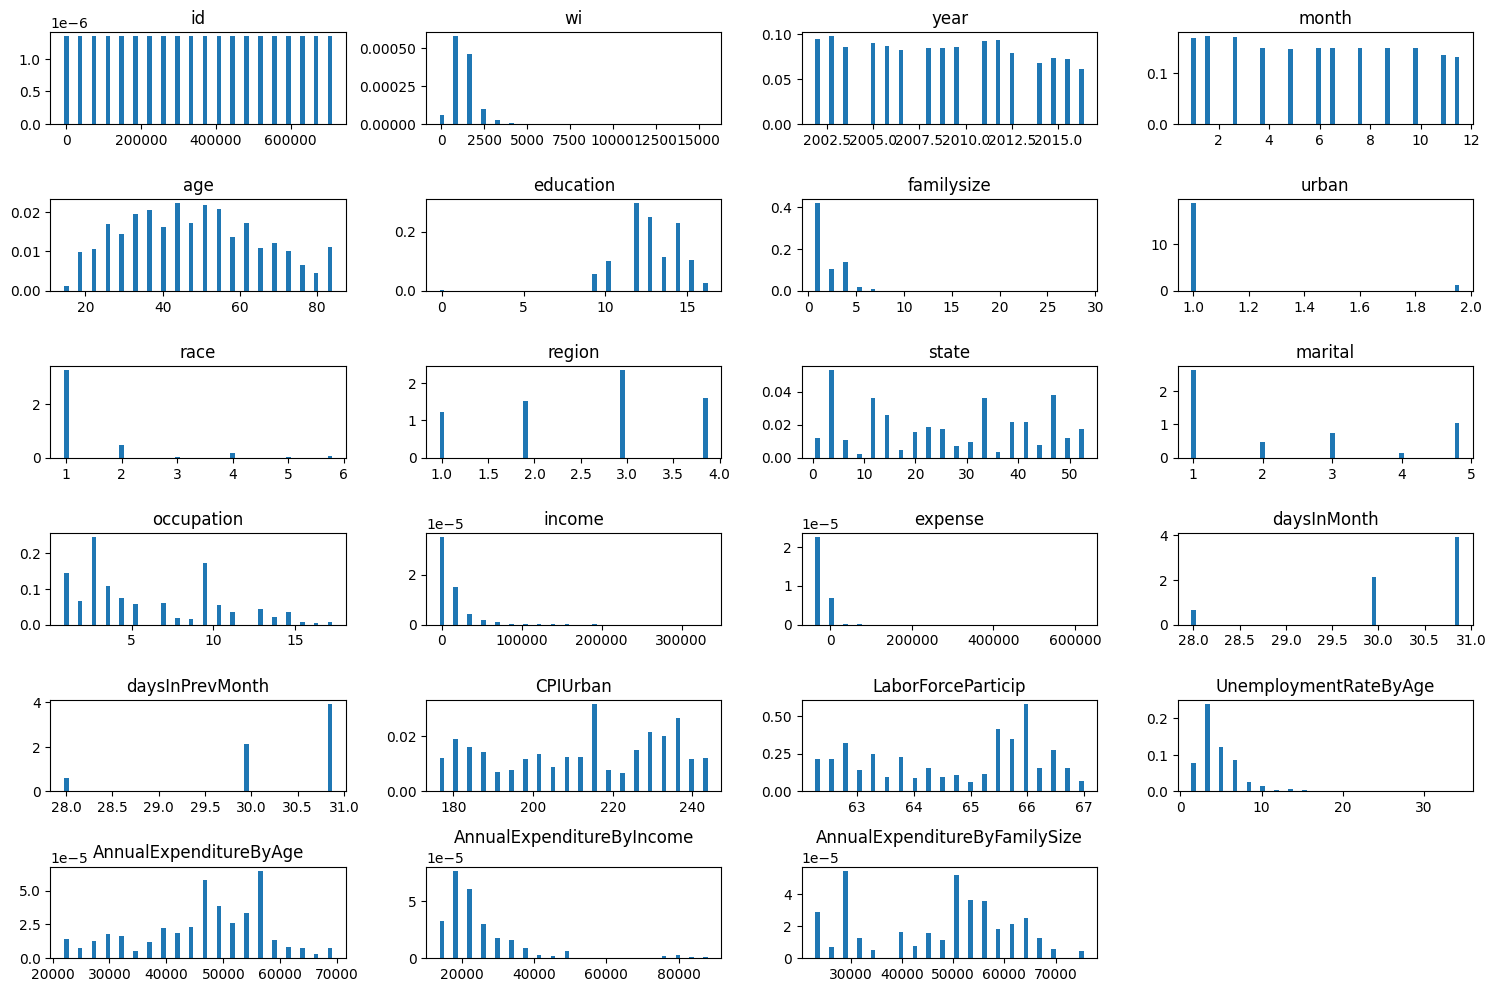

In [213]:
plt.figure(figsize=(15,10))
for i, col in enumerate(list(train_df.columns)):
    plt.subplot(6,4,i+1)
    
    valid = train_df[col]
    valid = valid[valid.notnull()]
    
    a_heights, a_bins = np.histogram(valid, bins=20, density=True)
    width = (a_bins[1] - a_bins[0])/3
    
    b_heights, b_bins = np.histogram(valid, bins=a_bins, density=True)
    plt.bar(b_bins[:-1], b_heights, width=width)

    plt.title(col)
    
plt.tight_layout(pad=1.0)

### Conclusions

* Distributions of most numerical variables are reasonably shaped, except income and expense that seem to have a long tail.
    * Expense distribution needs further exploration
* Distributions of many categorical variables are quite skewed.
* Occupation, region and state have a significant number of missing values, need plan for imputation on neural net models.
* Need special handling for categorical values

# Relationship between expense and independent variables

## Correlations

In [215]:
corrCols = ['year','month','age','familysize','income','education','CPIUrban', 'LaborForceParticip',
            'UnemploymentRateByAge', 'AnnualExpenditureByAge',
            'AnnualExpenditureByIncome', 'AnnualExpenditureByFamilySize']
methods = ['pearson', 'kendall', 'spearman']

corr_df = pd.DataFrame(columns = methods, index=corrCols)
for col in corrCols:
    corrVal = []
    for method in ['pearson', 'kendall', 'spearman']:
        if method == 'pearson' and col == 'education': # ordinal variable
            corrVal.append(np.nan)
            continue
        corrVal.append(train_df['expense'].corr(train_df[col], method))

    corr_df.loc[col] = corrVal

corr_df
#         print(f"{method}: {train_df['expense'].corr(train_df[['expense', 'wi']], method)}")

/Users/vgoudar/projects/hfEnv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5278: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


,pearson,kendall,spearman
year,0.0511,0.072064,0.104933
month,0.017014,0.023429,0.033684
age,-0.008418,-0.032721,-0.050528
familysize,0.134576,0.249879,0.335461
income,0.368773,0.42538,0.583935
education,NaN,0.244205,0.333674
CPIUrban,0.051386,0.071799,0.107412
LaborForceParticip,-0.03833,-0.053952,-0.080176
UnemploymentRateByAge,-0.064934,-0.050396,-0.074949
AnnualExpenditureByAge,0.130929,0.172199,0.253482


Strong corellation with income as well as familysize and education. Year may also prove informative. Relationships with other variables may exist as well, but are perhaps more non-linear.

In addition, the augmented features also seem covary with expense, particularly the annual expenditures. Of these, annual expenditure by age seems particularly informative relative to the age or year features.

## Relationship with categorical(-like) variables

In [214]:
train_df.columns

Index(['id', 'wi', 'year', 'month', 'age', 'education', 'familysize', 'urban',
       'race', 'region', 'state', 'marital', 'occupation', 'income', 'expense',
       'daysInMonth', 'daysInPrevMonth', 'CPIUrban', 'LaborForceParticip',
       'UnemploymentRateByAge', 'AnnualExpenditureByAge',
       'AnnualExpenditureByIncome', 'AnnualExpenditureByFamilySize'],
      dtype='object')

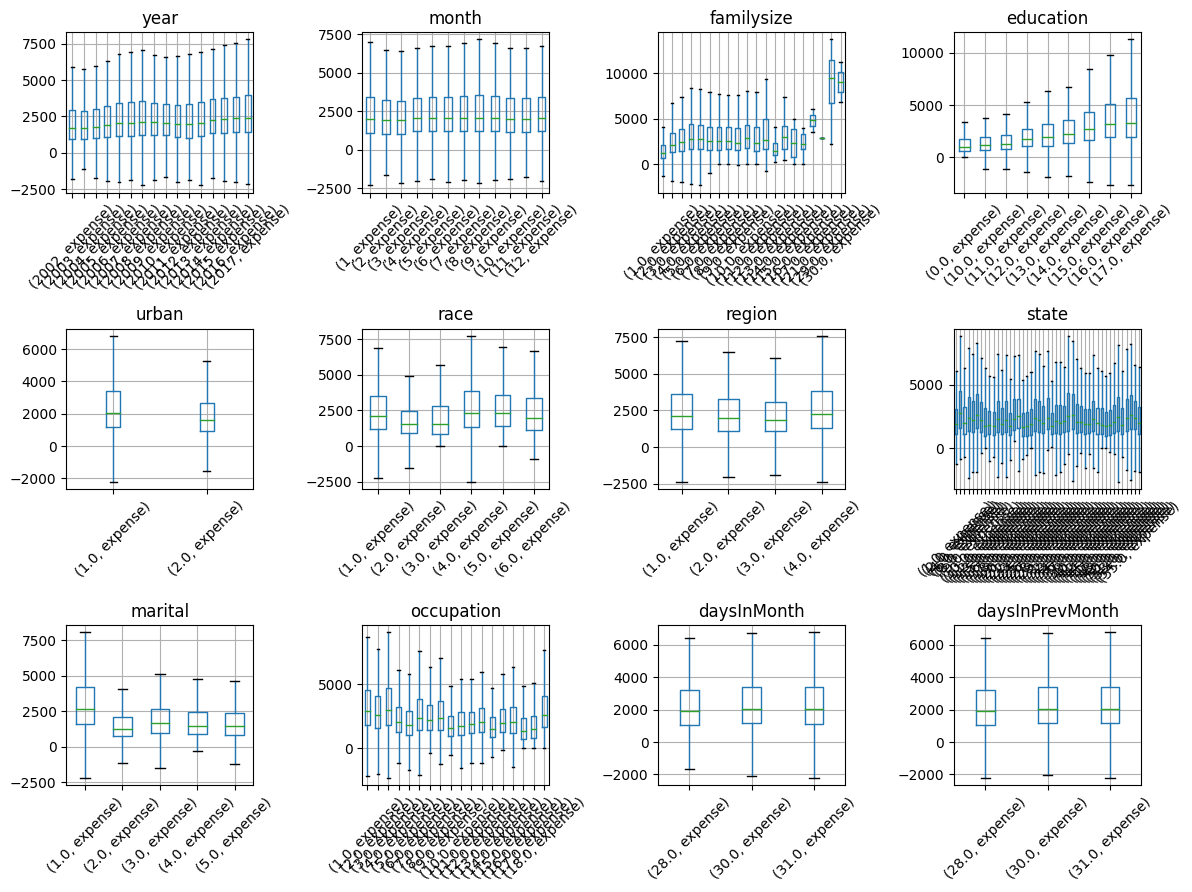

In [216]:
catLikeCols = ['year','month','familysize','education', 'urban','race','region','state','marital','occupation',
              'daysInMonth','daysInPrevMonth']

expense = train_df['expense']
f, axs = plt.subplots(3, 4,  figsize=(12,9))
for i, col in enumerate(catLikeCols):
    ax_yind = i%4
    ax_xind = i//4
    
    index = pd.MultiIndex.from_frame(train_df[['id',col]])
    g_df = train_df.set_index(index)
    grouped = g_df.groupby(level=col)
    grouped.boxplot(subplots=False, ax=axs[ax_xind, ax_yind], column='expense', rot=45, showfliers=False)  
    
    axs[ax_xind, ax_yind].set_title(col)
    
plt.tight_layout(pad=1.0)

There is clear modulation of expense by family size and education. State and occupation seem like other strong co-variate. Year, urban, race and marital status may be relevant factors as well.
New features i.e. days in month seem less informative.

# Further exploration of expense and customer weights

In [25]:
expense = train_df['expense']
cu_weight = train_df['wi']

## Summary statistics for expense and customer unit weight

In [26]:
expense_descr = expense.describe()
expense_descr.name = 'expense'
cu_weight_descr = cu_weight.describe()
cu_weight_descr.name = 'wi'
pd.merge(expense_descr, cu_weight_descr, left_index=True, right_index=True)

,expense,wi
count,741874.000000,741874.000000
mean,2869.427717,1742.251553
std,4308.140263,665.767268
min,-30502.000000,46.000000
25%,1145.000000,1365.000000
50%,2012.000000,1643.000000
75%,3374.000000,2030.000000
max,649569.000000,16224.000000


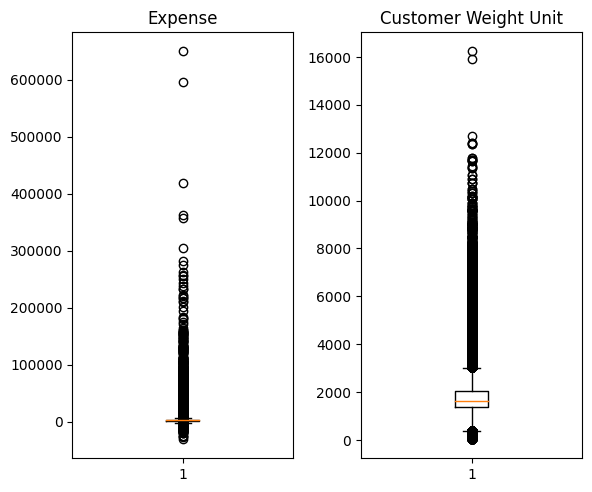

In [27]:
plt.figure(figsize=(6,5))

plt.subplot(1,2,1)
_ = plt.boxplot(expense)
plt.title('Expense')

plt.subplot(1,2,2)
_ = plt.boxplot(cu_weight)
plt.title('Customer Weight Unit')

plt.tight_layout(pad=1.0)

## Outlier detection for expense

In [28]:
outlier_threshold = 0.10

l = expense.quantile(outlier_threshold)
h = expense.quantile(1.0-outlier_threshold)
rng = h-l

lower = l-1.5*rng
upper = h+1.5*rng

print([lower, upper])

[-6684.0, 12732.0]


In [29]:
expense_no_outlier = expense[(expense >= lower) & (expense <= upper)]

print('Outliers form ' + str(100.0*(expense.shape[0]-expense_no_outlier.shape[0])/expense.shape[0]) + ' %')

Outliers form 1.8030015878707166 %


## Expense distribution after filtering outliers

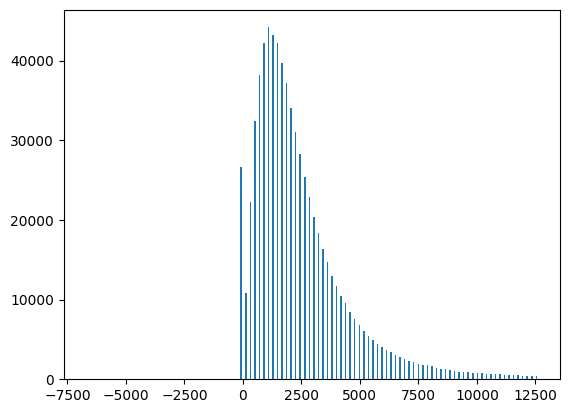

In [30]:
a_heights, a_bins = np.histogram(expense_no_outlier, bins=100)
width = (a_bins[1] - a_bins[0])/3
_ = plt.bar(a_bins[:-1], a_heights,width=width)

Distribution looks long-tailed with a second mode at 0 (possibly due to clipping or data collection guidelines)

### Exploration of customer weights

Text(0, 0.5, 'Weights')

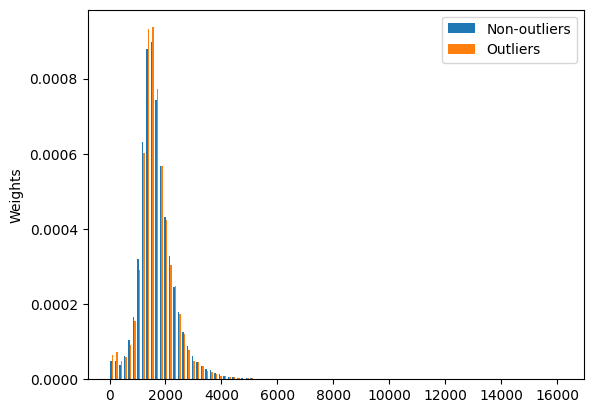

In [31]:
cu_weight_expOutlier = cu_weight[(expense < lower) | (expense > upper)]

a_heights, a_bins = np.histogram(cu_weight, bins=100, density=True)
width = (a_bins[1] - a_bins[0])/3
plt.bar(a_bins[:-1], a_heights, width=width,label='Non-outliers')

b_heights, b_bins = np.histogram(cu_weight_expOutlier, bins=a_bins, density=True)
plt.bar(b_bins[:-1]+width, b_heights, width=width,label='Outliers')
plt.legend()
plt.ylabel('Weights')

In [32]:
cu_weight_expOutlier_descr = cu_weight_expOutlier.describe()
cu_weight_expOutlier_descr.name = 'wi_expOutliers'
pd.merge(cu_weight_descr, cu_weight_expOutlier_descr, left_index=True, right_index=True)

,wi,wi_expOutliers
count,741874.000000,13376.000000
mean,1742.251553,1720.935556
std,665.767268,656.967925
min,46.000000,57.000000
25%,1365.000000,1370.000000
50%,1643.000000,1632.000000
75%,2030.000000,2001.000000
max,16224.000000,10183.000000


Outliers aren't also the least important (which would have produced better scores) or the most important customers (which would have produced worse scores) !

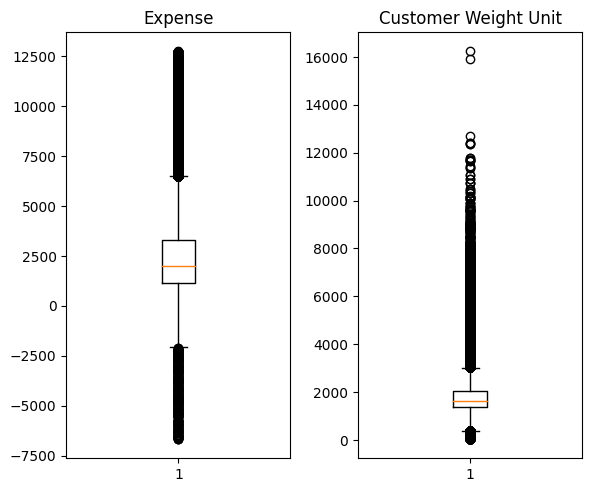

In [33]:
plt.figure(figsize=(6,5))

plt.subplot(1,2,1)
_ = plt.boxplot(expense_no_outlier)
plt.title('Expense')

cu_weight_no_expOutlier = cu_weight[(expense >= lower) & (expense <= upper)]

plt.subplot(1,2,2)
_ = plt.boxplot(cu_weight_no_expOutlier)
plt.title('Customer Weight Unit')

plt.tight_layout(pad=1.0)

## Relationship between expense and weights

In [35]:
for method in ['pearson', 'kendall', 'spearman']:
    print(f'{method}: {expense.corr(cu_weight, method)}')

pearson: -0.005056301286513739
kendall: 0.007295723799699727
spearman: 0.011021985478291502


Text(0, 0.5, 'Customer weight unit')

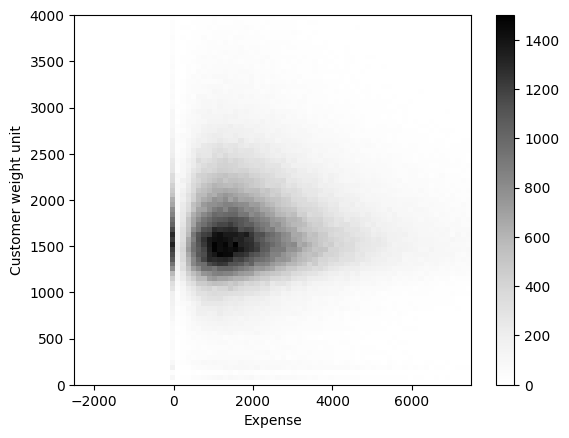

In [166]:
_ = plt.hist2d(expense_no_outlier, cu_weight_no_expOutlier, 
               bins=(75, 75), 
               cmap=plt.cm.Greys,
               range=[[-2500, 7500], [0, 4000]])
plt.colorbar()
plt.xlabel('Expense')
plt.ylabel('Customer weight unit')